# Explaination of the harmonic product spectrum

In [3]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import os
import soundfile as sf

Reinitialising the inputs to the algorithm

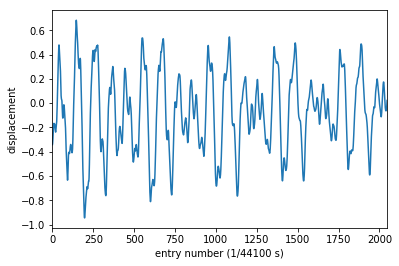

In [4]:
chunksize = 2048
notes_dict = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
file_name = os.path.join(fileDir, '../sounds/u_ea.wav')
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)

t_start = 1.501
signal = ref[int(t_start * 44100): int(t_start * 44100 + 2050), 0]
signal_length = chunksize

signal_to_ayse = signal[:2048]

plt.plot(signal_to_ayse)
plt.xlabel("entry number (1/44100 s)")
plt.ylabel("displacement")
ax = plt.gca()
ax.set_xlim([0, 2048])
plt.show()

## Taking the Discrete Fourier Transform

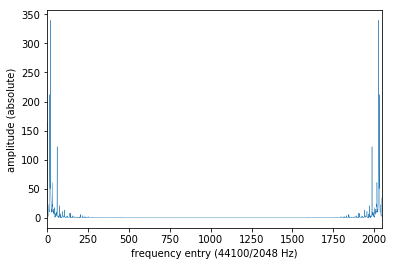

In [5]:
spectrum = np.absolute(np.fft.fft(signal_to_ayse))

plt.plot(spectrum, lw=0.4)
plt.xlabel("frequency entry (44100/2048 Hz)")
plt.ylabel("amplitude (absolute)")
ax = plt.gca() 
ax.set_xlim([0, 2048])
plt.show()

## Zooming into the relevant part of the spectrum
Removing the second half of the spectrum, and the lowest frequencies

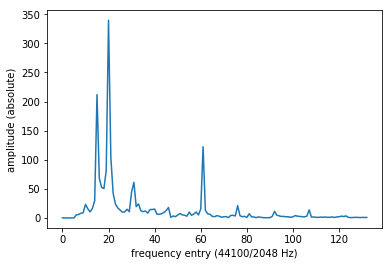

In [6]:
spectrum[:6] = 0.0  # anything below middle C is muted
spectrum[1024:] = 0.0  # mute second half of spectrum, lazy to change code

plt.plot(spectrum[:133])
plt.xlabel("frequency entry (44100/2048 Hz)")
plt.ylabel("amplitude (absolute)")
plt.show()

## Taking different scales of the spectrum
We stretch $\hat{s}[k]$ to $\hat{s}^\ast[k]$ 

$\hat{s}^\ast[k] = \hat{s}[k/6]$ for $k = 0 \enspace mod \enspace 6$

If $k$ in $\hat{s}^\ast[k]$ is not divisible by 6, we interpolate between its adjacent points.

For $k = 1 \enspace mod \enspace 6$ :<br>
$\hat{s}^\ast[k] = \frac{5}{6} \cdot \hat{s}\left[\frac{k-1}{6}\right] + \frac{1}{6} \cdot \hat{s}\left[\frac{k+5}{6}\right]$ <br> ... etc

[//]: # ($\hat{s}^\ast[k] = \frac{2}{6} \hat{s}[(k-2)/6] + \frac{2}{6} \hat{s}[(k+4)/6]$ for $k = 2\mod 6$)

[//]: # ($\hat{s}^\ast[k] = \frac{3}{6} \hat{s}[(k-3)/6] + \frac{3}{6} \hat{s}[(k+3)/6]$ for $k = 3\mod 6$)

[//]: # ($\hat{s}^\ast[k] = \frac{4}{6} \hat{s}[(k-4)/6] + \frac{4}{6} \hat{s}[(k+2)/6]$ for $k = 4\mod 6$)

[//]: # ($\hat{s}^\ast[k] = \frac{5}{6} \hat{s}[(k-5)/6] + \frac{5}{6} \hat{s}[(k+1)/6]$ for $k = 5\mod 6$)

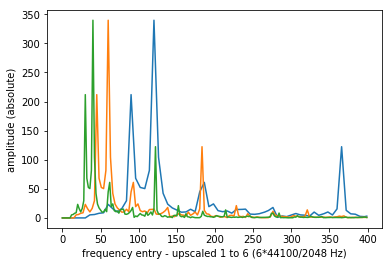

In [7]:
scale1 = [0.0] * (2048 * 6)
scale2 = [0.0] * (2048 * 6)
scale3 = [0.0] * (2048 * 6)

# upsampling the original scale spectrum, 6 for 1
scale1_f1 = np.convolve(spectrum, [5.0 / 6.0, 1.0 / 6.0])[1:]
scale1_f2 = np.convolve(spectrum, [4.0 / 6.0, 2.0 / 6.0])[1:]
scale1_f3 = np.convolve(spectrum, [3.0 / 6.0, 3.0 / 6.0])[1:]
scale1_f4 = np.convolve(spectrum, [2.0 / 6.0, 4.0 / 6.0])[1:]
scale1_f5 = np.convolve(spectrum, [1.0 / 6.0, 5.0 / 6.0])[1:]
scale1[::6] = spectrum
scale1[1::6] = scale1_f5
scale1[2::6] = scale1_f4
scale1[3::6] = scale1_f3
scale1[4::6] = scale1_f2
scale1[5::6] = scale1_f1
# downsampling from the 6 for 1 upsample
scale2[:2048 * 3] = scale1[::2]
scale3[:2048 * 2] = scale1[::3]

plt.plot(scale1[:400])
plt.plot(scale2[:400])
plt.plot(scale3[:400])
plt.xlabel("frequency entry - upscaled 1 to 6 (6*44100/2048 Hz)")
plt.ylabel("amplitude (absolute)")
plt.show()

## Multiplying the different scales of the spectrum

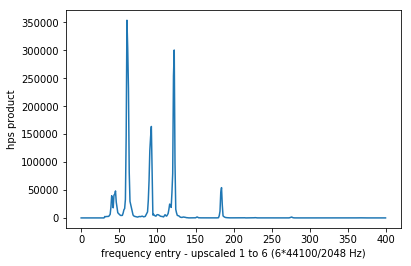

215.33203125 at entry 60


In [8]:
hps = np.prod((scale1, scale2, scale3), axis=0)  # the "product" in harmonic product spectrum
hps_max = np.argmax(hps)  # determine the location of the peak of hps result
# calculate the corresponding frequency of the peak
ffreq = hps_max * 44100.0 / (2048.0 * 6.0)  # sampling rate / (chunksize * upsampling value)

plt.plot(hps[:400])
plt.xlabel("frequency entry - upscaled 1 to 6 (6*44100/2048 Hz)")
plt.ylabel("hps product")
plt.show()

print("{} at entry {}".format(ffreq, hps_max))

## Calculating the fraction of the area under graph due to the spectrum

In [9]:
spectrum = np.array(spectrum[:int(0.5 * chunksize) + 1])  # to be plotted

# TODO: add some weights, adapt spread based on how high ffreq is
total_energy = np.sum(scale1)
total_energy_due_to_ffreq = np.sum(scale1[::hps_max]) \
                            + np.sum(scale1[1::hps_max]) + np.sum(scale1[:hps_max - 1:hps_max]) \
#                             + np.sum(scale1[2::hps_max]) + np.sum(scale1[:hps_max - 2:hps_max]) \
#  + np.sum(scale1[3::hps_max]) + np.sum(scale1[:hps_max - 3:hps_max]) \
#  + np.sum(scale1[4::hps_max]) + np.sum(scale1[:hps_max - 4:hps_max]) \
#  + np.sum(scale1[5::hps_max]) + np.sum(scale1[:hps_max - 5:hps_max]) \
#  + np.sum(scale1[6::hps_max]) + np.sum(scale1[:hps_max - 6:hps_max])

portion_of_energy = (total_energy_due_to_ffreq / total_energy)

print("total: {}".format(total_energy))
print("note: {}".format(total_energy_due_to_ffreq))
print("fraction: {}".format(portion_of_energy))

total: 13424.3682209
note: 953.916659072
fraction: 0.0710585886332


## Print note if note detected

In [10]:
if portion_of_energy > 0.05:
    # printing note in solfage form
    note_no = -3 + (np.log2(ffreq) - np.log2(220.0)) * 12.0  # take logarithm and find note
    note_no_rounded = np.round(note_no)  # round off to nearest note
    note_no_difference = note_no - note_no_rounded
    octave_no = 4 + int(note_no_rounded // 12)
    solfate_no = int(note_no_rounded) % 12
    note = str(notes_dict[solfate_no]) + str(octave_no)

    print ("{:.2f}Hz({:02}) {:.2f}, {:3s} {:+.2f}"
           .format(ffreq, int(note_no_rounded), portion_of_energy, note, note_no_difference))
    note_detected = True
else:
    print("inharmonic sound ({:.2f}) detected at {:.3f}s"
          .format(portion_of_energy, t_start + i * 2048. / 44100.))

215.33Hz(-3) 0.07, A3  -0.37
